In [1]:
from lib.NeuralNet import *
from lib.Optimizer import Adam,SGD,AdaGrad,RMSProp

| TIME:     0.15s | EPOCH:     1 | LOSS: 0.08556572 |
| TIME:    10.54s | EPOCH:   100 | LOSS: 0.06964322 |
| TIME:    22.22s | EPOCH:   200 | LOSS: 0.04817654 |
| TIME:    33.54s | EPOCH:   300 | LOSS: 0.02012073 |
| TIME:    44.44s | EPOCH:   400 | LOSS: 0.00766398 |
| TIME:    55.17s | EPOCH:   500 | LOSS: 0.00587419 |
| TIME:    66.78s | EPOCH:   600 | LOSS: 0.00437799 |
| TIME:    78.17s | EPOCH:   700 | LOSS: 0.00115883 |
| TIME:    88.84s | EPOCH:   800 | LOSS: 0.00078514 |
| TIME:   100.81s | EPOCH:   900 | LOSS: 0.00073917 |
| TIME:   112.59s | EPOCH:  1000 | LOSS: 0.00006772 |


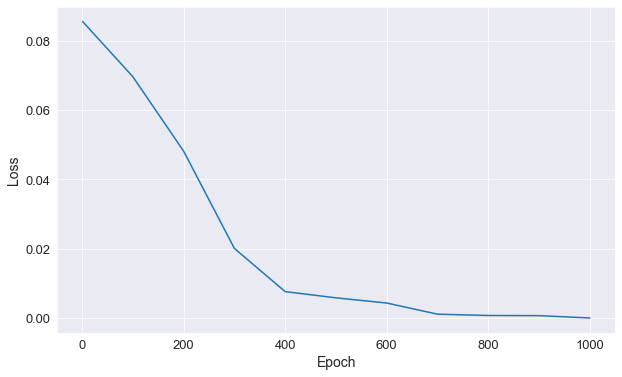

In [3]:
X = np.random.rand(5000,100)
y = np.random.rand(5000,1)
W1,b1,W2,b2,W3,b3 = FitModel(X,y,n_iter=1000,batch_size=500,lr=1e-3,update=SGD,print_every_epochs=100,print_graph=True)